# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [71]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
import seaborn as sns

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 257 ms (started: 2023-02-20 16:05:55 +09:00)


In [38]:
start = '20180101'
end = '20191231'
#end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 242 ms (started: 2023-02-20 14:58:56 +09:00)


In [59]:
def run_backtest(start, df_bt, kwargs, strategy='custom'):
    df = {symbol: df_bt}
    end = start + timedelta(hold_period)
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    return [start, end] + result['summary']

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n} % done')
        return n
    else:
        return last_print

time: 1.82 ms (started: 2023-02-20 15:27:35 +09:00)


In [99]:
df_compare = pd.DataFrame()

time: 1.7 ms (started: 2023-02-20 16:24:01 +09:00)


# Buy & hold

## Settings

In [39]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 11.6 ms (started: 2023-02-20 14:59:00 +09:00)


In [40]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 4.26 ms (started: 2023-02-20 14:59:01 +09:00)


In [42]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1 ms (started: 2023-02-20 14:59:02 +09:00)


In [43]:
# testing
dates_start = dates_start[:50]

time: 978 µs (started: 2023-02-20 14:59:04 +09:00)


## SC01

In [9]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.1 ms (started: 2023-02-19 23:52:33 +09:00)


In [10]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 40.9 s (started: 2023-02-19 23:52:34 +09:00)


In [11]:
df_result['return'].agg(['mean','min','max'])

mean   -11.566873
min    -19.743635
max     -5.533235
Name: return, dtype: float64

time: 22.8 ms (started: 2023-02-19 23:53:15 +09:00)


In [12]:
#df_compare = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)

df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.4 ms (started: 2023-02-19 23:53:15 +09:00)


## SC02

In [13]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.33 ms (started: 2023-02-19 23:53:15 +09:00)


In [14]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 42.7 s (started: 2023-02-19 23:53:15 +09:00)


In [15]:
df_result['return'].agg(['mean','min','max'])

mean    -4.837210
min    -10.521555
max     -1.752492
Name: return, dtype: float64

time: 15.6 ms (started: 2023-02-19 23:53:58 +09:00)


In [16]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13 ms (started: 2023-02-19 23:53:58 +09:00)


## SC03

In [96]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.1 ms (started: 2023-02-20 16:22:43 +09:00)


In [97]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 40.7 s (started: 2023-02-20 16:22:44 +09:00)


In [98]:
df_result['return'].agg(['mean','min','max'])

mean   -4.461819
min    -9.894740
max    -1.633529
Name: return, dtype: float64

time: 19.2 ms (started: 2023-02-20 16:23:25 +09:00)


In [100]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 16.1 ms (started: 2023-02-20 16:24:06 +09:00)


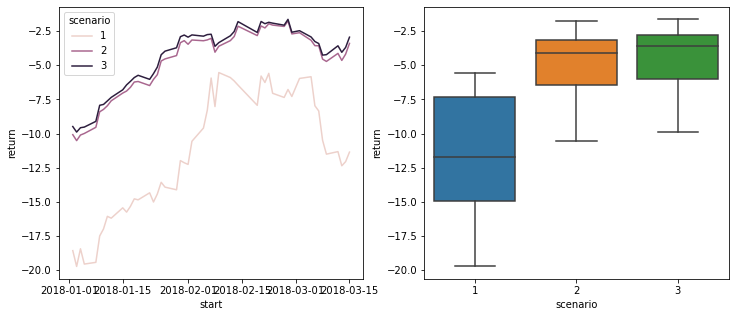

time: 987 ms (started: 2023-02-19 23:58:45 +09:00)


In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
_ = sns.lineplot(data=df_compare.reset_index(), x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df_compare.reset_index(), x='scenario', y='return', ax=ax2)

# Technical Indicator

## Settings

In [18]:
import tulipy as ti
import numpy as np

time: 19.3 ms (started: 2023-02-20 14:52:57 +09:00)


In [107]:
def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


time: 6.77 ms (started: 2023-02-20 16:39:52 +09:00)


In [114]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 14 ms (started: 2023-02-20 16:49:46 +09:00)


In [40]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 4.26 ms (started: 2023-02-20 14:59:01 +09:00)


In [42]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1 ms (started: 2023-02-20 14:59:02 +09:00)


In [43]:
# testing
dates_start = dates_start[:50]

time: 978 µs (started: 2023-02-20 14:59:04 +09:00)


## SC01: MACD

### calc tech indi

In [89]:
df_macd = calc_macd(df_bt['close'])

time: 9.57 ms (started: 2023-02-20 16:19:28 +09:00)


In [90]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 15 ms (started: 2023-02-20 16:19:30 +09:00)


In [92]:
df_bt = finish_custom(df_bt)

time: 175 ms (started: 2023-02-20 16:19:50 +09:00)


### bactesting

In [101]:
scenario = 't1'
n_buy = 50 # krw 200,000 every buy

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.17 ms (started: 2023-02-20 16:24:18 +09:00)


In [102]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 40.3 s (started: 2023-02-20 16:24:18 +09:00)


In [103]:
df_result['return'].agg(['mean','min','max'])

mean   -1.395520
min    -3.674243
max    -0.242843
Name: return, dtype: float64

time: 19.4 ms (started: 2023-02-20 16:24:59 +09:00)


In [104]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.2 ms (started: 2023-02-20 16:24:59 +09:00)


## SC02: Bollinger Bands

### calc tech indi

In [115]:
df_bbands = calc_bbands(df_bt['close'])

time: 2.69 ms (started: 2023-02-20 16:49:55 +09:00)


In [116]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 13.7 ms (started: 2023-02-20 16:49:55 +09:00)


In [117]:
df_bt = finish_custom(df_bt)

time: 372 ms (started: 2023-02-20 16:49:56 +09:00)


<AxesSubplot:xlabel='dt'>

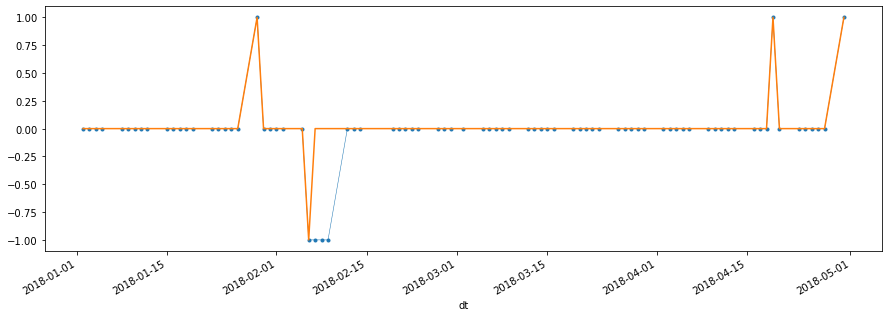

time: 612 ms (started: 2023-02-20 16:50:12 +09:00)


In [119]:
dt = '2018-05-01'
fig, ax = plt.subplots(figsize=(15,5))
df_bt.loc[:dt].custom.plot(ax=ax, marker='.', lw=0.5)
df.loc[:dt].custom.plot(ax=ax)

### bactesting

In [101]:
scenario = 't1'
n_buy = 50 # krw 200,000 every buy

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.17 ms (started: 2023-02-20 16:24:18 +09:00)


In [102]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 40.3 s (started: 2023-02-20 16:24:18 +09:00)


In [103]:
df_result['return'].agg(['mean','min','max'])

mean   -1.395520
min    -3.674243
max    -0.242843
Name: return, dtype: float64

time: 19.4 ms (started: 2023-02-20 16:24:59 +09:00)


In [104]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.2 ms (started: 2023-02-20 16:24:59 +09:00)


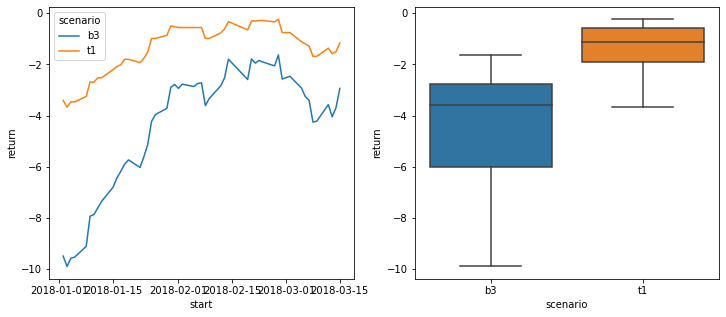

time: 839 ms (started: 2023-02-20 16:26:49 +09:00)


In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
_ = sns.lineplot(data=df_compare.reset_index(), x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df_compare.reset_index(), x='scenario', y='return', ax=ax2)